# Unsupervised Learning Trading Strategy
Utilizes S&amp;P 500 stocks for portfolio optimization.
- Download SP500 stocks prices data.
- Calculate different technical indicators and features for each stock.
- Aggregate on monthly level and filter for each month only top 150 most liquid stocks.
- Calculate monthly returns for different time-horizons to add to features.
- Download Fama-French Factors and calculate rolling factor betas for each stock.
- For each month fit a K-means clustering model to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio portfolio optimization.
- Visualize the portfolio returns and compare to SP500 returns.

In [60]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install statsmodels
!pip install pandas_datareader
!pip install datetime
!pip install yfinance
!pip install sklearn
!pip install PyPortfolioOpt
!pip install pandas_ta

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [61]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

## 1. Download/Load SP500 Stock Prices Data

In [188]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['VLTO', 'SOLV', 'GEV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


Price               adj close       close  ...        open       volume
date       ticker                          ...                         
2015-09-29 A        31.483559   33.740002  ...   33.360001    2252400.0
           AAL      37.361610   39.180000  ...   39.049999    7478800.0
           AAPL     24.651131   27.264999  ...   28.207500  293461600.0
           ABBV     36.334904   52.790001  ...   53.099998   12842800.0
           ABT      33.478706   39.500000  ...   39.259998   12287500.0
...                       ...         ...  ...         ...          ...
2023-09-26 XYL      88.736298   89.519997  ...   90.379997    1322400.0
           YUM     122.211006  124.010002  ...  124.239998    1500600.0
           ZBH     111.534821  112.459999  ...  116.769997    3610500.0
           ZBRA    223.960007  223.960007  ...  225.970001     355400.0
           ZTS     175.547699  176.869995  ...  176.580002    1463200.0

[987967 rows x 6 columns]

## 2. Calculate Features and Technical Indicators for Each Stock
- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

In [189]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close  ...      macd  dollar_volume
date       ticker                          ...                         
2015-09-29 A        31.483559   33.740002  ...       NaN      70.913568
           AAL      37.361610   39.180000  ...       NaN     279.420012
           AAPL     24.651131   27.264999  ...       NaN    7234.160250
           ABBV     36.334904   52.790001  ...       NaN     466.641901
           ABT      33.478706   39.500000  ...       NaN     411.369604
...                       ...         ...  ...       ...            ...
2023-09-26 XYL      88.736298   89.519997  ... -2.159189     117.344880
           YUM     122.211006  124.010002  ... -1.363695     183.389836
           ZBH     111.534821  112.459999  ... -0.881067     402.696470
           ZBRA    223.960007  223.960007  ... -1.600791      79.595386
           ZTS     175.547699  176.869995  ... -1.188278     256.861393

[987967 rows x 14 columns]

## 3. Agregate to monthly level and filter top 150 most liquid stocks for each month

In [190]:
# To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  ...       atr      macd
date       ticker                             ...                    
2015-11-30 A          135.992822   39.023182  ... -1.033887  0.567157
           AAL        287.915795   39.429935  ...  0.190822 -0.418772
           AAPL      4023.984111   26.854143  ... -0.967900 -0.142789
           ABBV       337.563934   40.393528  ... -0.526809  0.145677
           ABT        211.659065   38.293560  ... -1.064842  0.335557
...                          ...         ...  ...       ...       ...
2023-09-30 OTIS       154.361757   78.356499  ... -1.028320 -1.534536
           ABNB      1633.500725  132.279999  ... -1.006939 -0.037854
           CEG        196.670368  107.862030  ... -0.436215  0.366876
           GEHC       212.275850   66.130219  ... -0.893478 -1.116463
           KVUE       670.804286   20.006193  ... -0.899746 -1.435621

[46648 rows x 9 columns]

In [191]:
# Calculate 5-year rolling average of dollar volume for each stock before filtering.
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol  ...       atr      macd
date       ticker                                ...                    
2016-10-31 AAL      39.134331         -0.000176  ...  0.402199  1.131596
           AAPL     26.212481         -0.002468  ... -1.038688 -0.195978
           ABBV     40.245125         -0.046691  ... -0.893132 -0.760593
           ABT      34.293465         -0.007492  ... -1.035224 -0.650888
           ACN     103.569618         -0.004643  ... -0.996806 -0.135456
...                       ...               ...  ...       ...       ...
2023-09-30 XOM     113.372093         -0.000065  ...  0.601335  1.400623
           MRNA     98.120003          0.000146  ... -0.529511 -0.376899
           UBER     44.270000          0.000441  ... -0.746098 -0.133973
           CRWD    160.479996          0.000144  ... -0.744862  0.245950
           ABNB    132.279999          0.000213  ... -1.006939 -0.037854

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for Different Time Horizons as Features

In [192]:
# To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol  ...  return_9m  return_12m
date       ticker                                ...                       
2017-10-31 AAL      45.534172         -0.000363  ...   0.007008    0.012702
           AAPL     39.713902         -0.001055  ...   0.038941    0.035228
           ABBV     67.491135         -0.034008  ...   0.047273    0.044026
           ABT      48.493374         -0.005190  ...   0.031320    0.029294
           ACN     129.399719         -0.003925  ...   0.027398    0.018728
...                       ...               ...  ...        ...         ...
2023-09-30 XOM     113.372093         -0.000065  ...   0.008747    0.027037
           MRNA     98.120003          0.000146  ...  -0.064976   -0.015431
           UBER     44.270000          0.000441  ...   0.066838    0.043691
           CRWD    160.479996          0.000144  ...   0.047942   -0.002216
           ABNB    132.279999          0.000213  ...   0.049124    0.019401

[10344 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas

In [193]:
# We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.
# The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.
# We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.009617
           VZ     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.056890
           WFC    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.015500
           WMT    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.000677
           XOM    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.046947

[10344 rows x 6 columns]

In [194]:
# Filter out stocks with less than 10 months of data.

observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.009617
           VZ     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.056890
           WFC    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.015500
           WMT    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.000677
           XOM    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.046947

[10314 rows x 6 columns]

In [195]:
# Calculate Rolling Factor Betas
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456835 -0.444629 -0.314191 -0.077989  0.802008
           VZ      0.332723 -0.166038  0.265928  0.311101  0.108625
           WFC     1.120621  0.297482  2.062607 -0.441340 -1.519518
           WMT     0.700774 -0.313572 -0.413679 -0.141574  0.508836
           XOM     0.983099 -1.094429  1.756406 -0.640017 -0.368886

[10314 rows x 5 columns]

In [196]:
# Join the rolling factors data to the main features dataframe.
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10094 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10094 non-null  float64
 1   rsi               10094 non-null  float64
 2   bb_low            10094 non-null  float64
 3   bb_mid            10094 non-null  float64
 4   bb_high           10094 non-null  float64
 5   atr               10094 non-null  float64
 6   macd              10094 non-null  float64
 7   return_1m         10094 non-null  float64
 8   return_2m         10094 non-null  float64
 9   return_3m         10094 non-null  float64
 10  return_6m         10094 non-null  float64
 11  return_9m         10094 non-null  float64
 12  return_12m        10094 non-null  float64
 13  Mkt-RF            10094 non-null  float64
 14  SMB               10094 non-null  float64
 15  HML       

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

In [205]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi  ...       CMA  cluster
date       ticker                               ...                   
2017-10-31 AAL            -0.000363  41.051795  ...  0.563337        0
           AAPL           -0.001055  69.196669  ...  0.458386        2
           ABBV           -0.034008  55.247833  ...  0.164054        3
           ABT            -0.005190  53.844872  ...  0.970502        3
           ACN            -0.003925  69.365236  ...  0.168630        2
...                             ...        ...  ...       ...      ...
2023-09-30 WMT            -0.000041  54.722485  ...  0.642483        2
           XOM            -0.000065  59.440176  ... -0.284575        1
           MRNA            0.000146  38.747314  ...  0.989911        3
           UBER            0.000441  45.005268  ... -0.449948        3
           CRWD            0.000144  51.534803  ... -0.814519        2

[10094 rows x 19 columns]

In [206]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

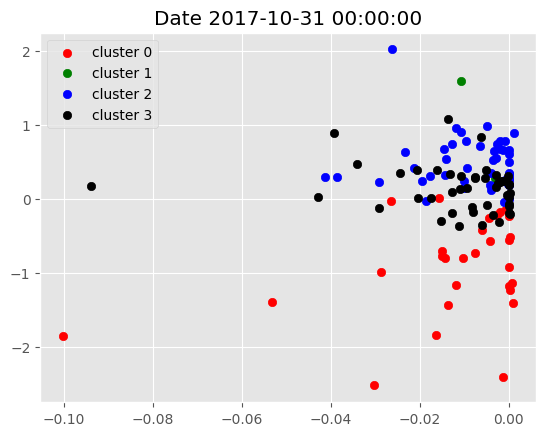

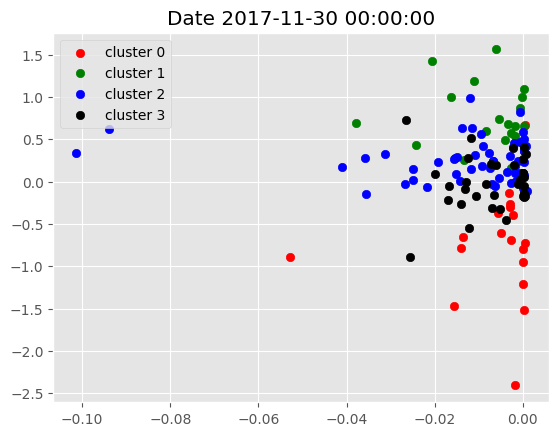

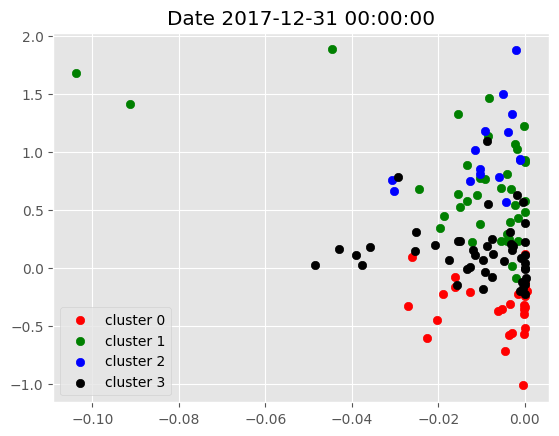

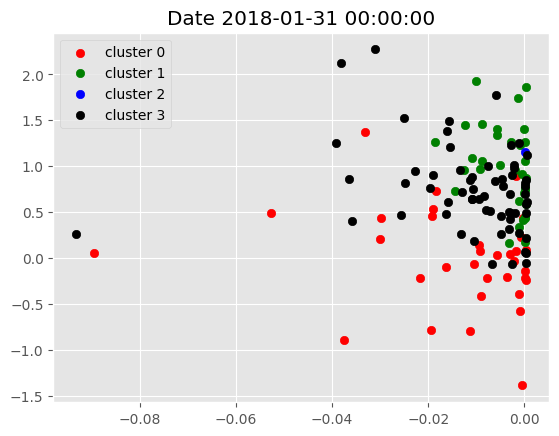

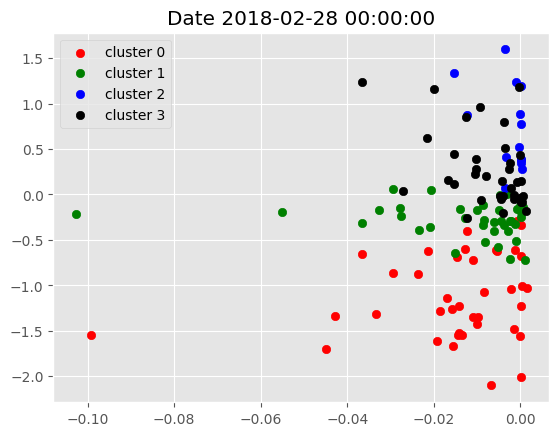

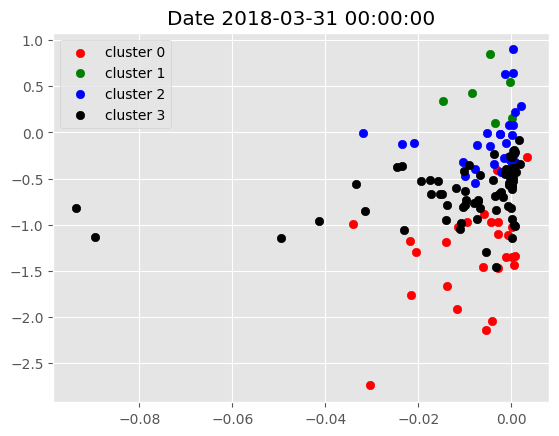

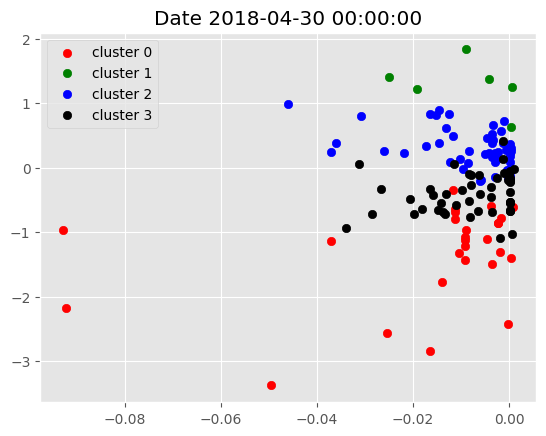

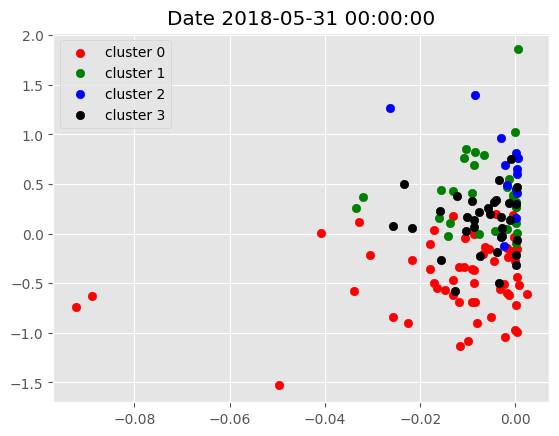

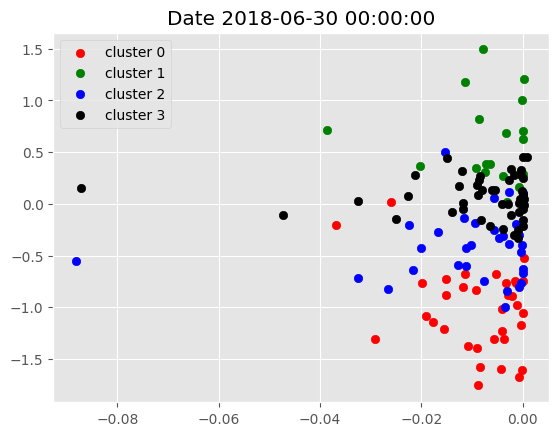

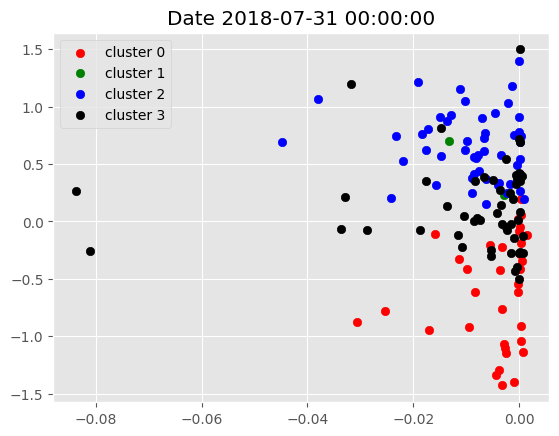

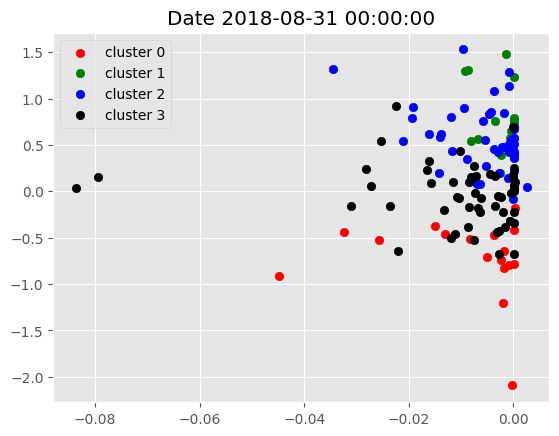

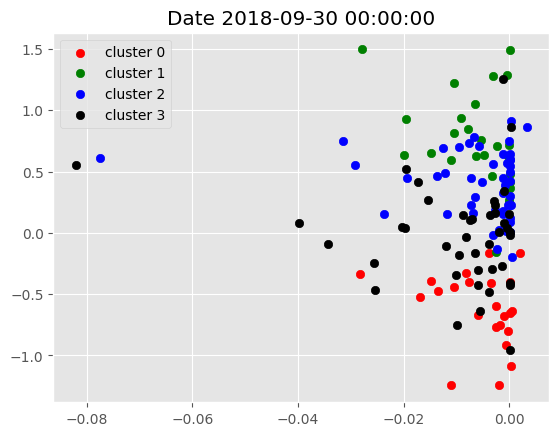

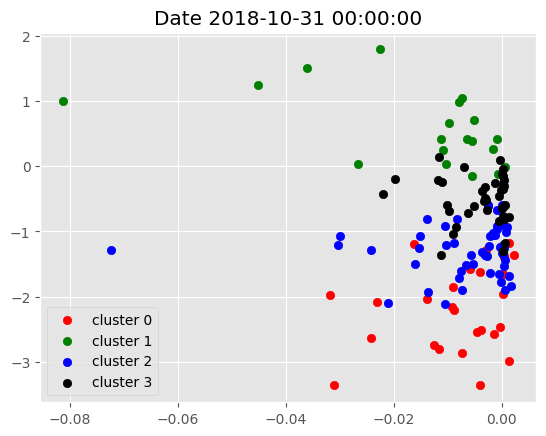

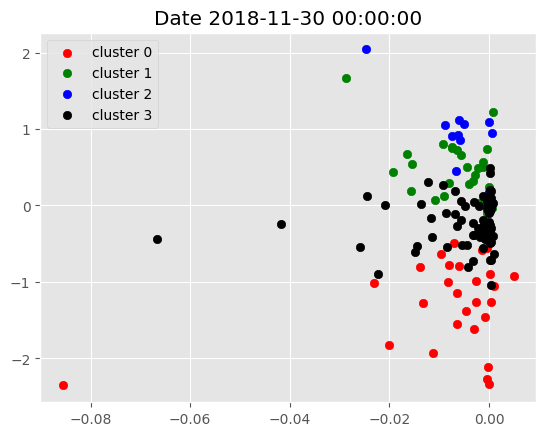

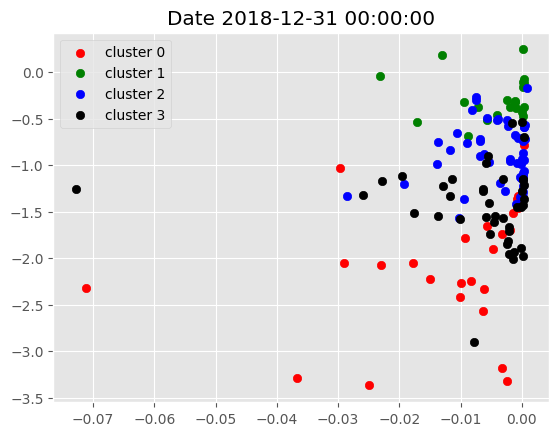

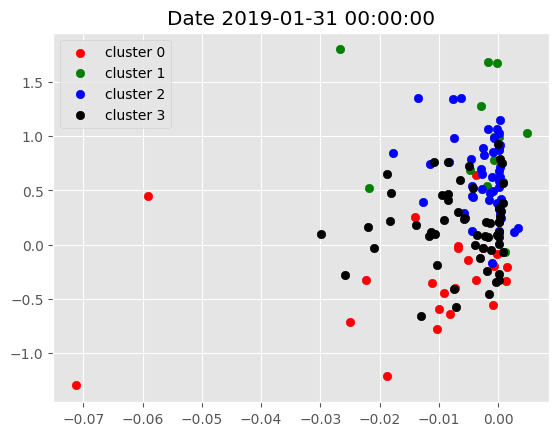

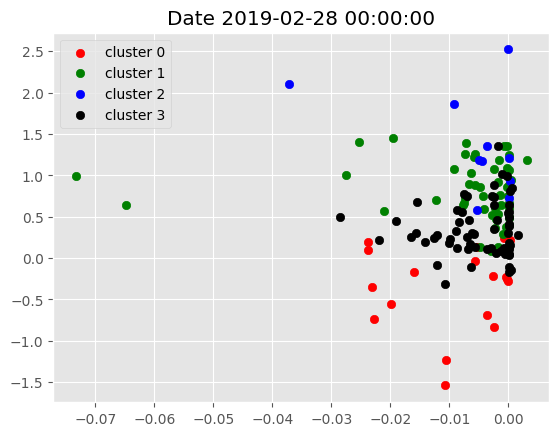

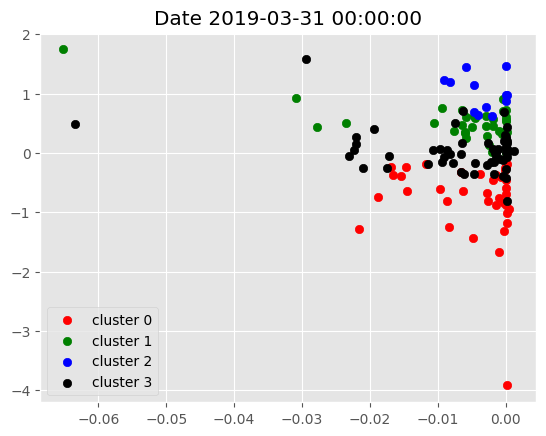

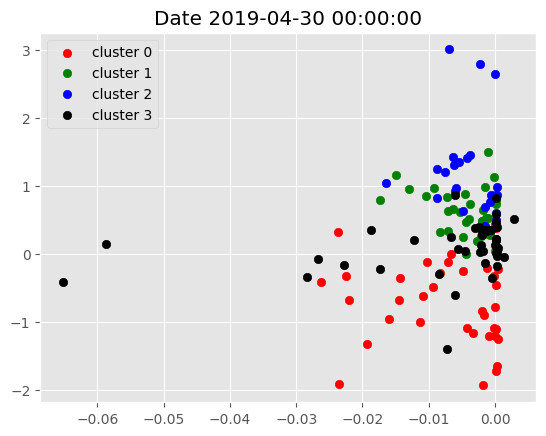

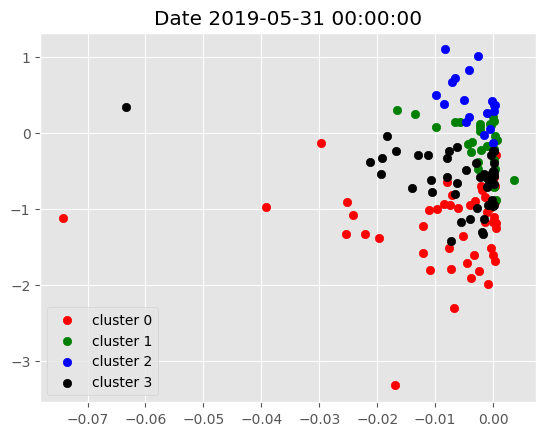

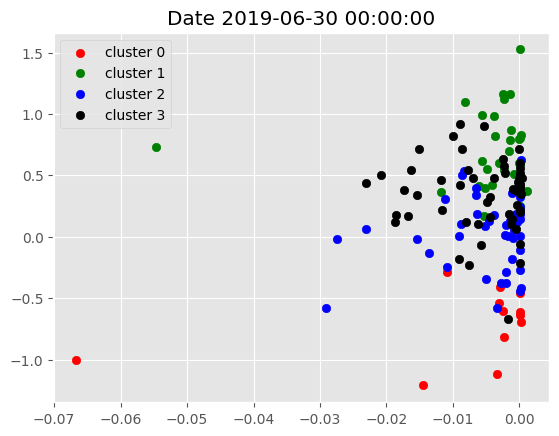

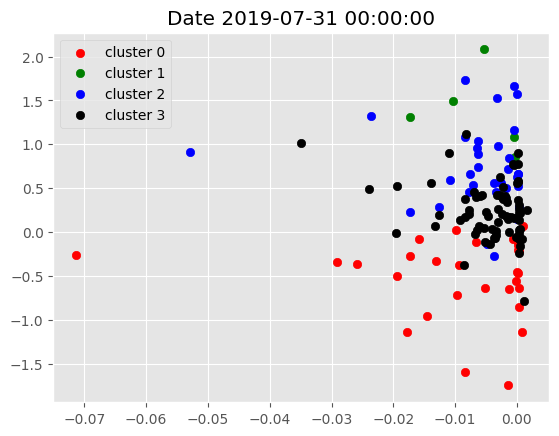

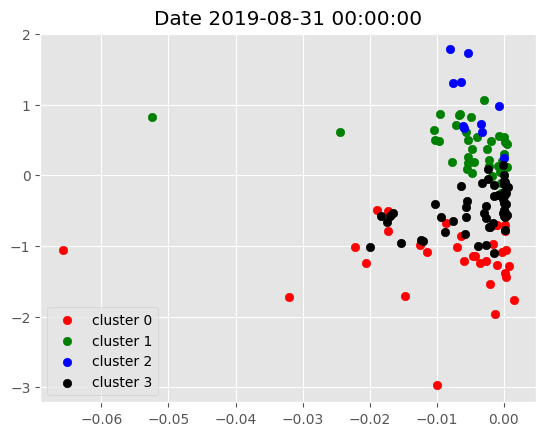

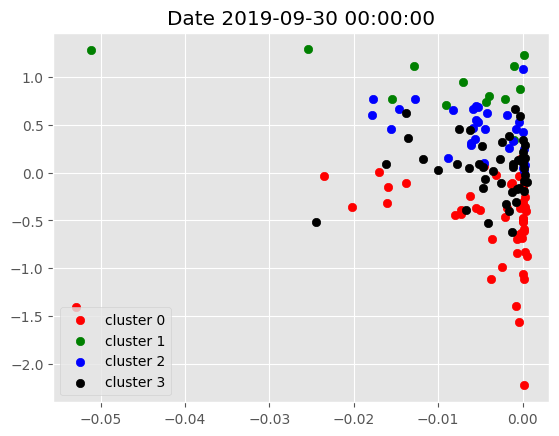

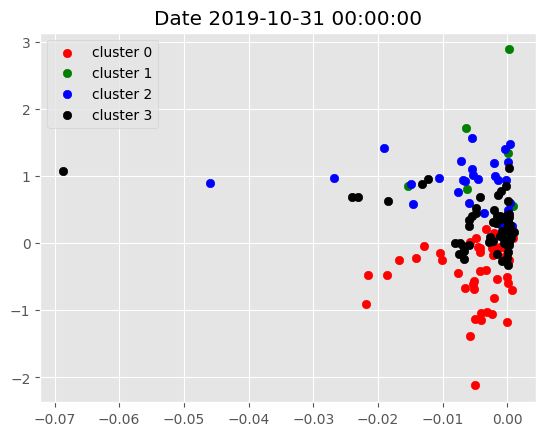

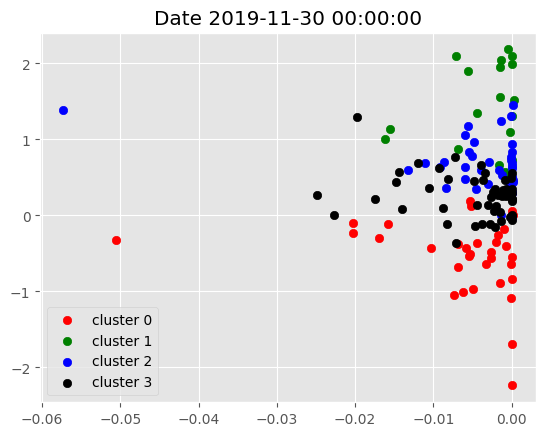

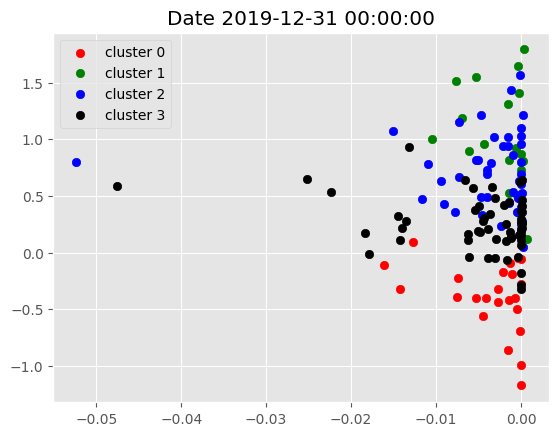

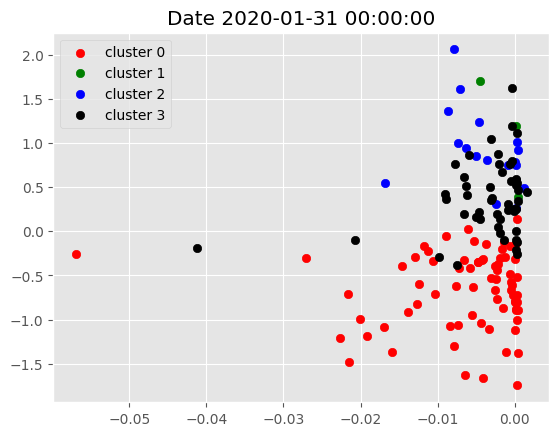

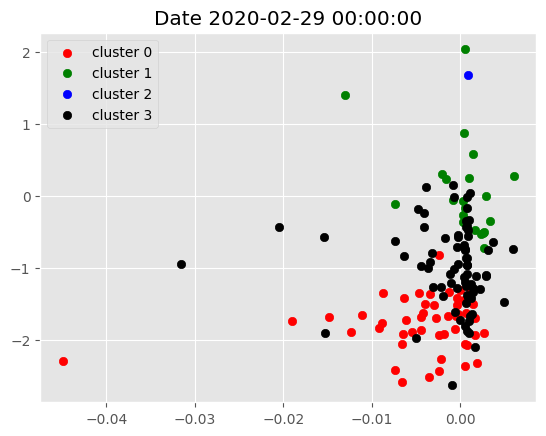

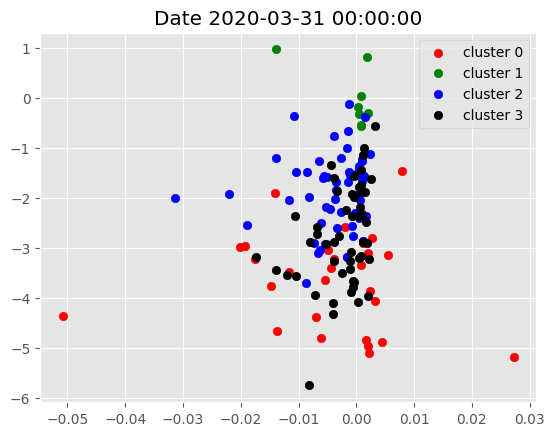

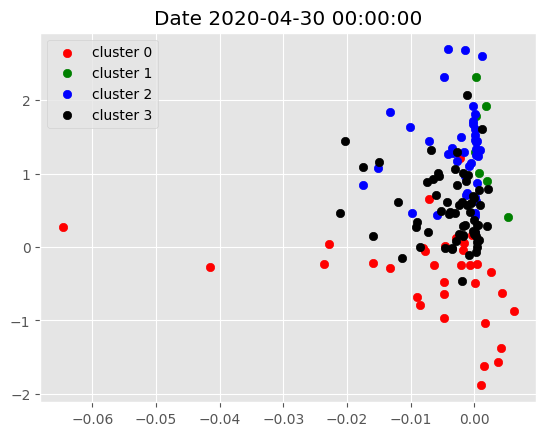

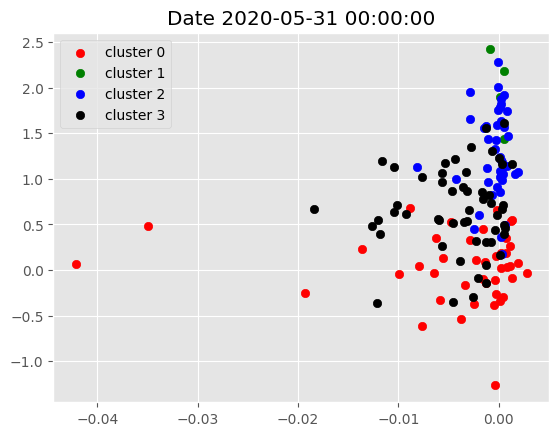

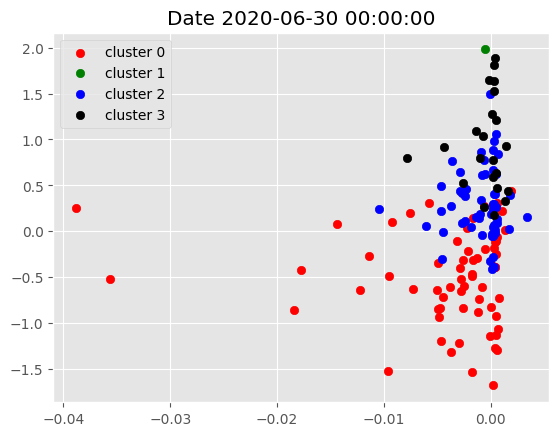

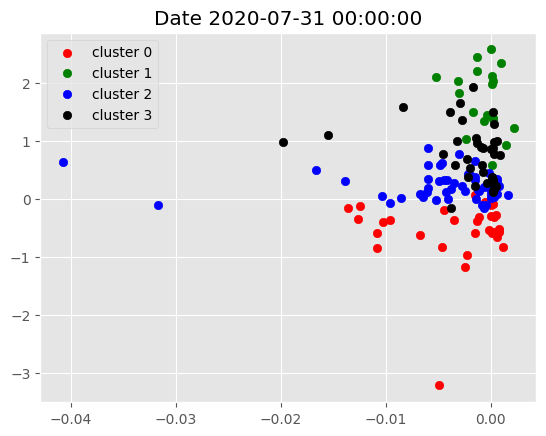

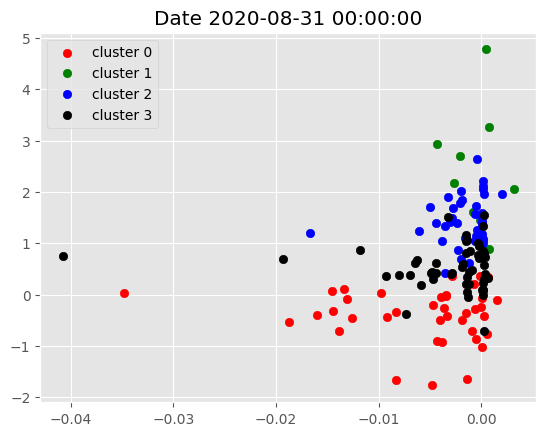

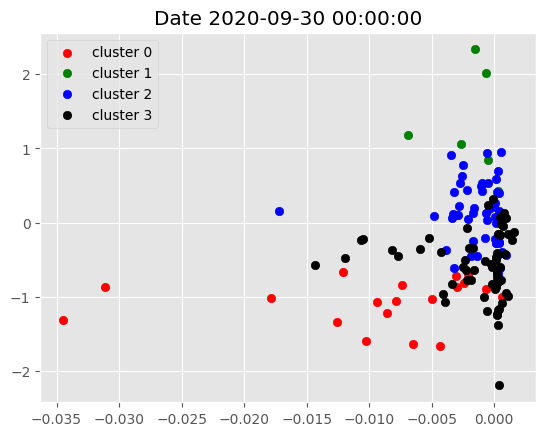

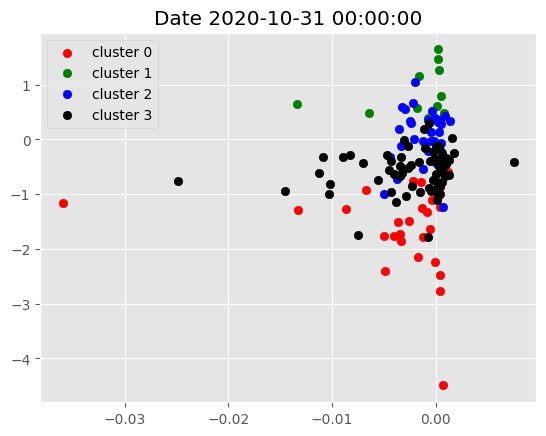

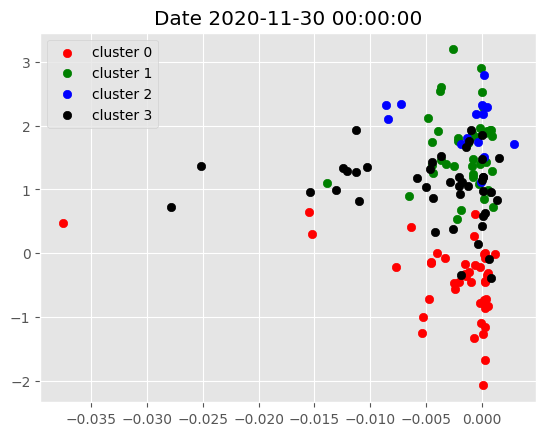

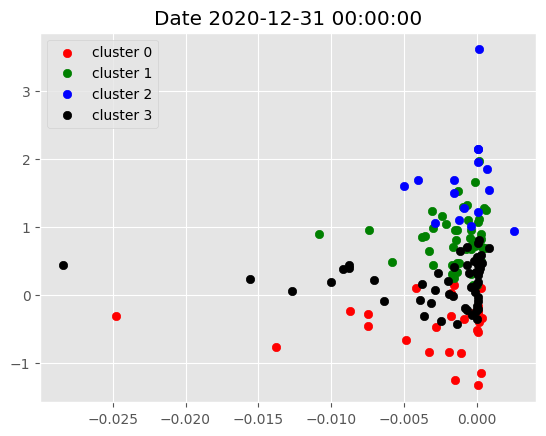

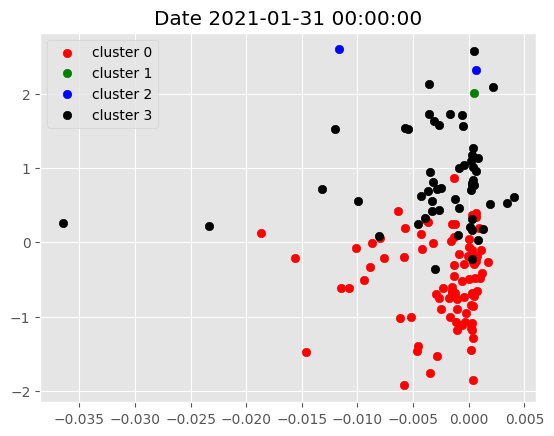

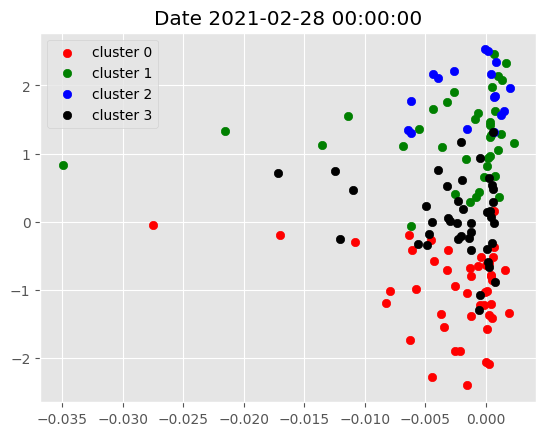

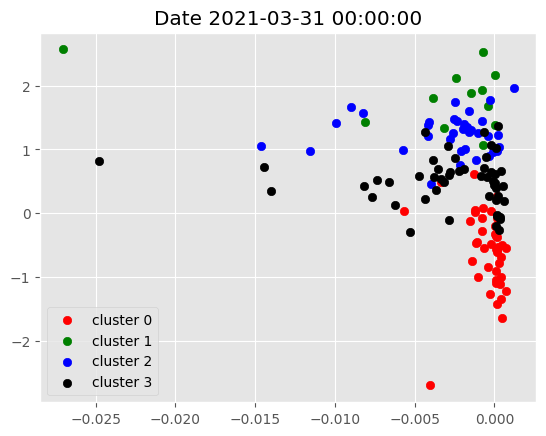

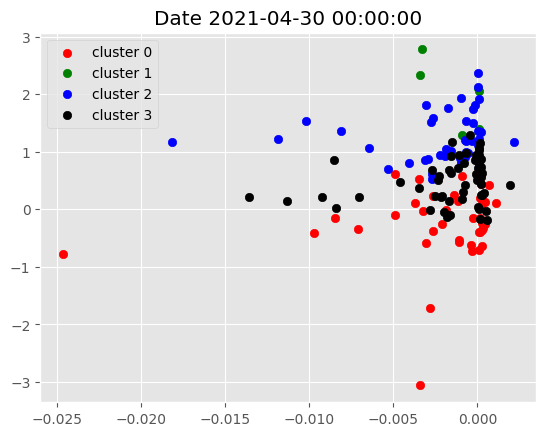

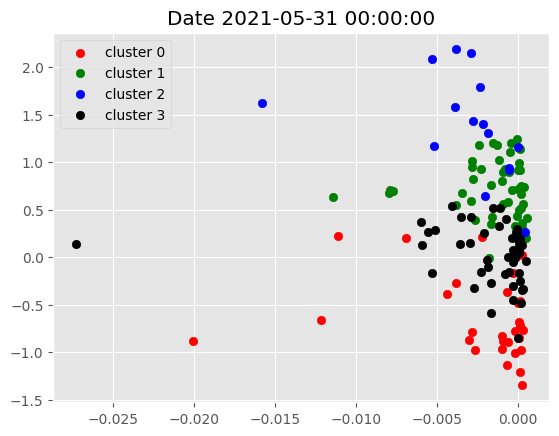

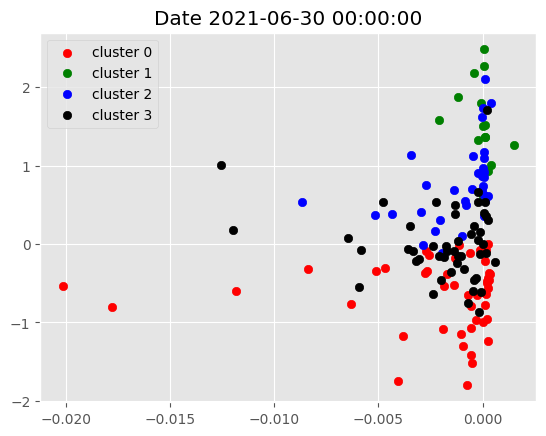

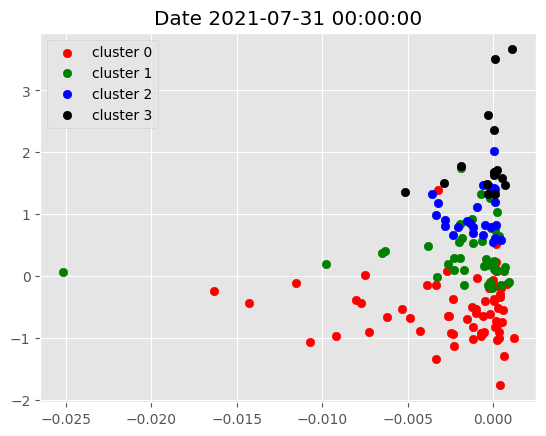

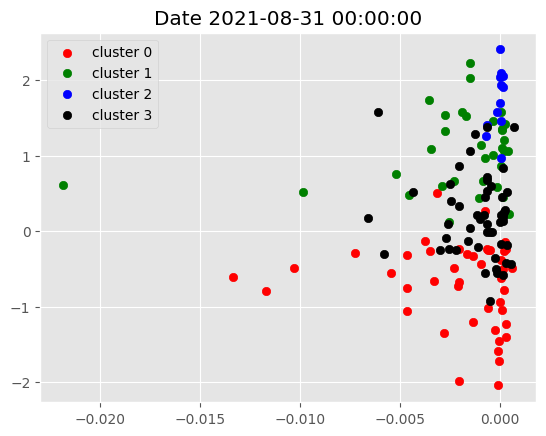

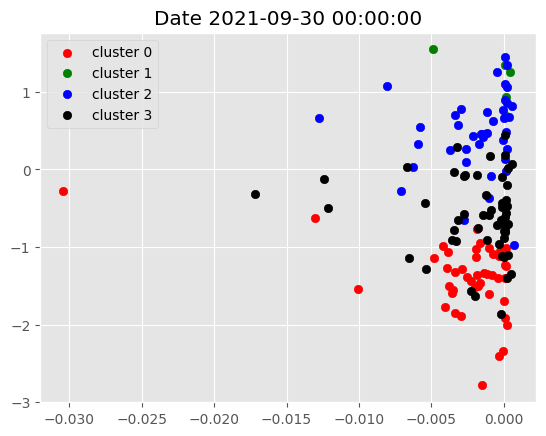

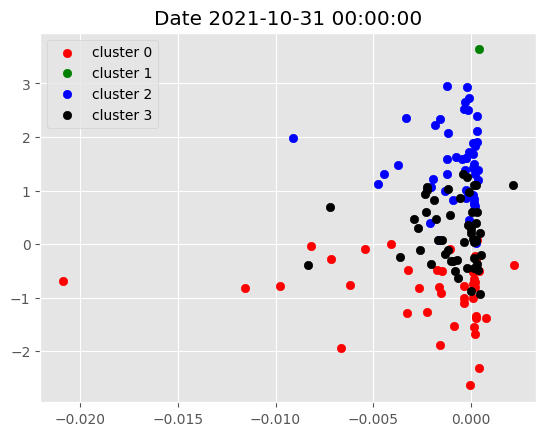

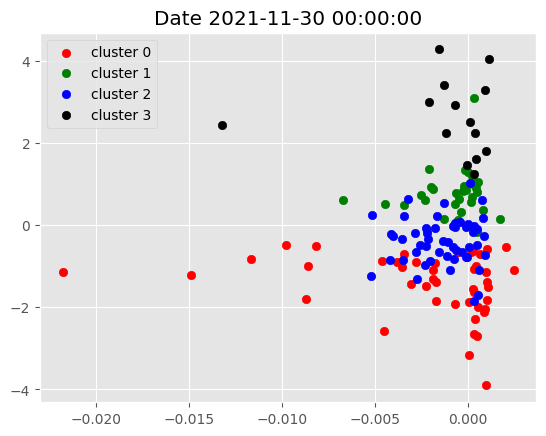

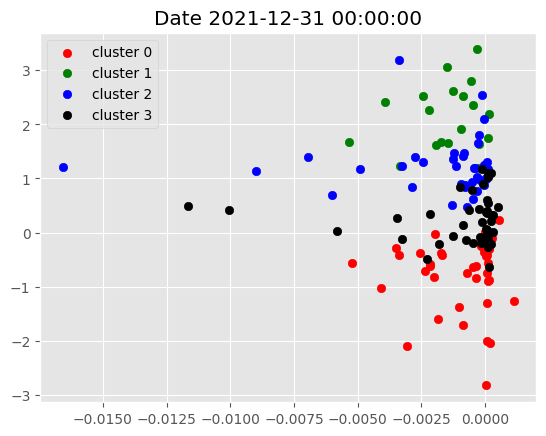

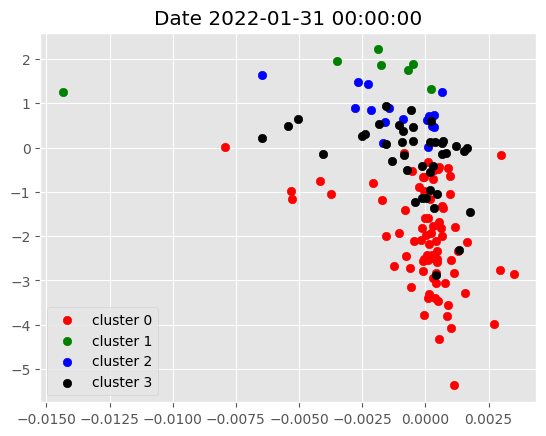

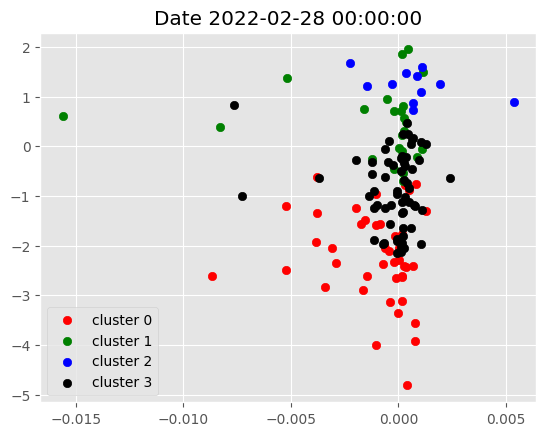

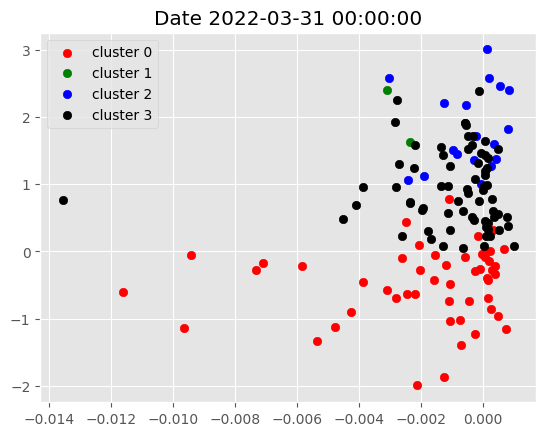

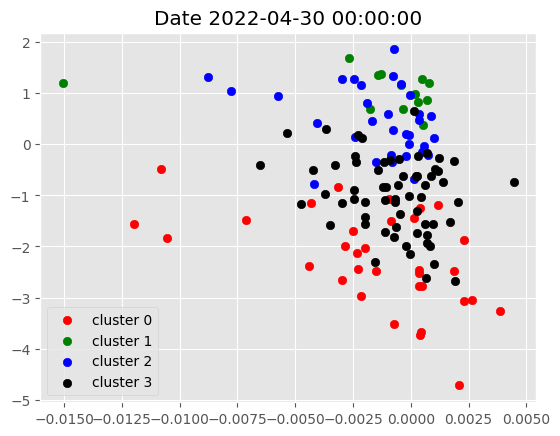

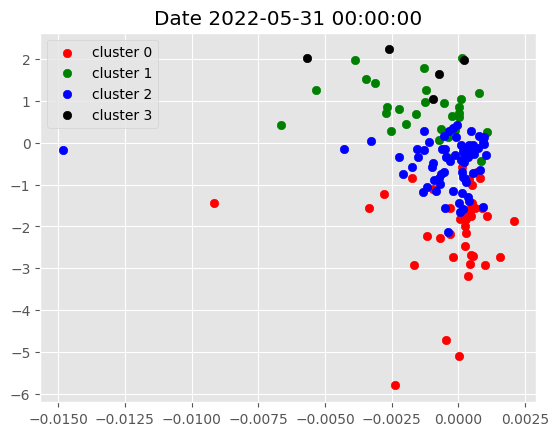

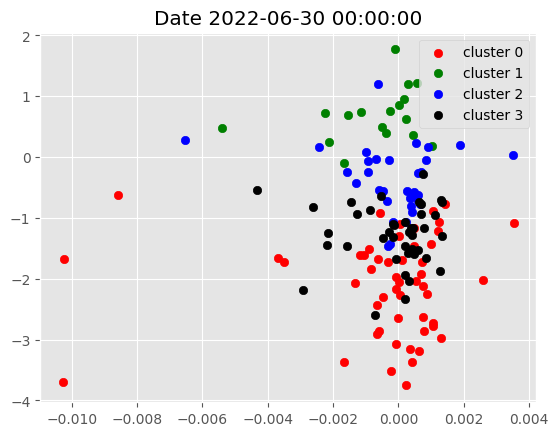

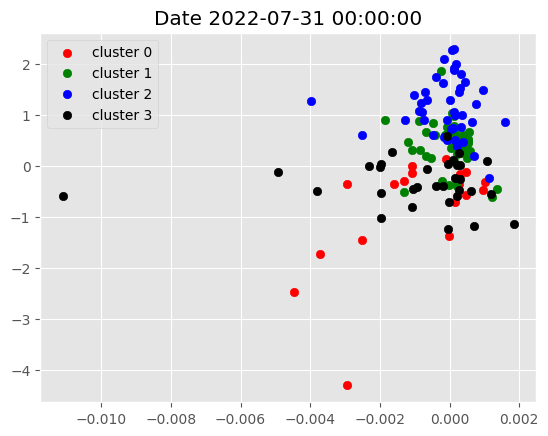

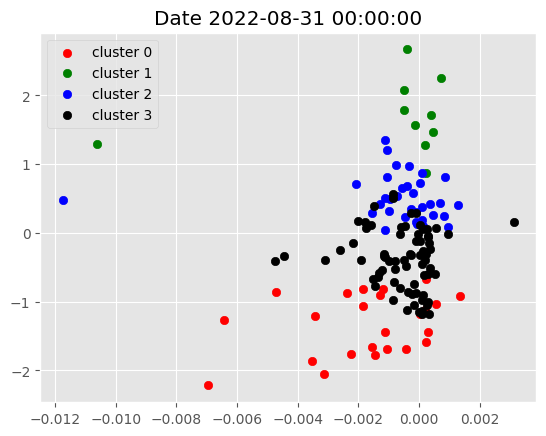

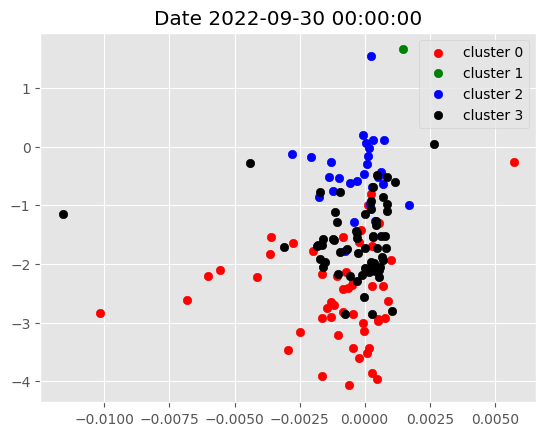

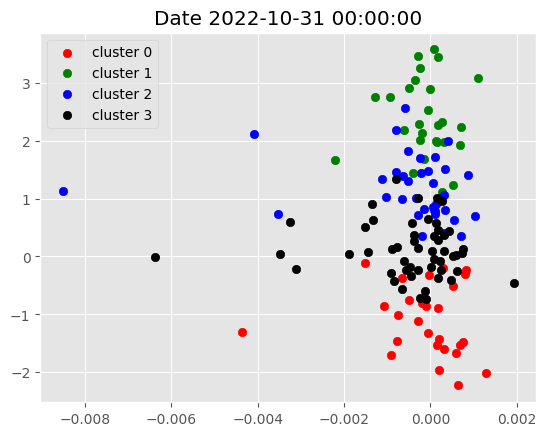

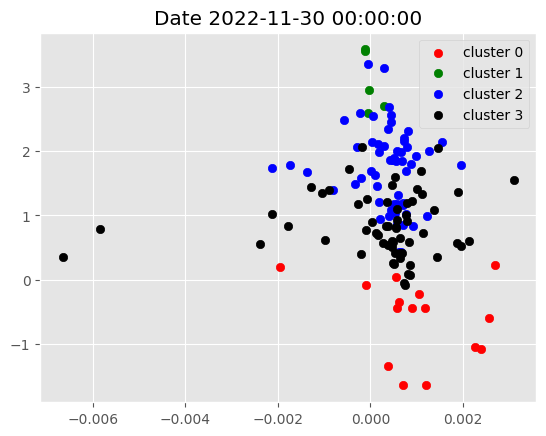

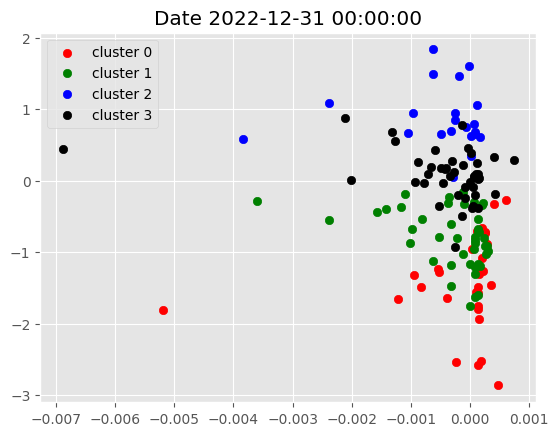

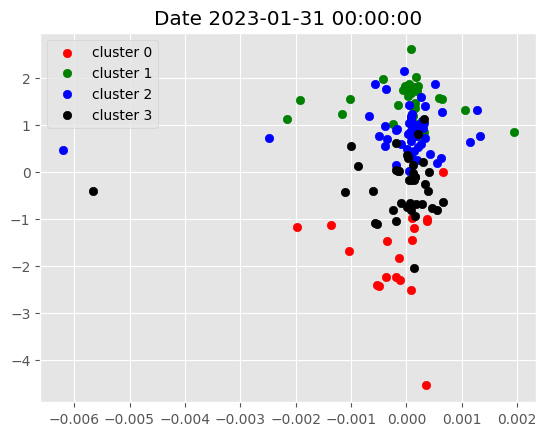

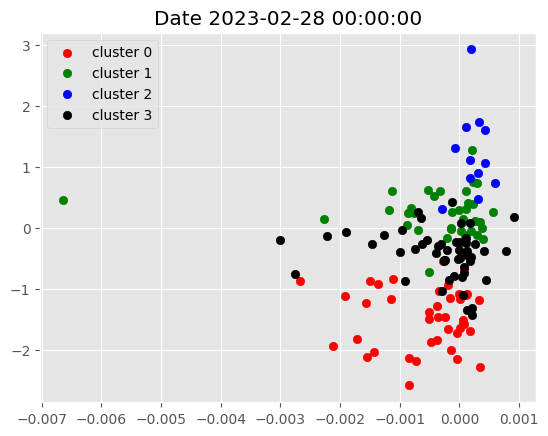

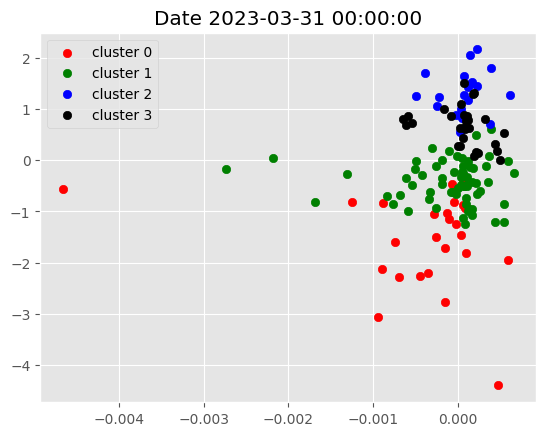

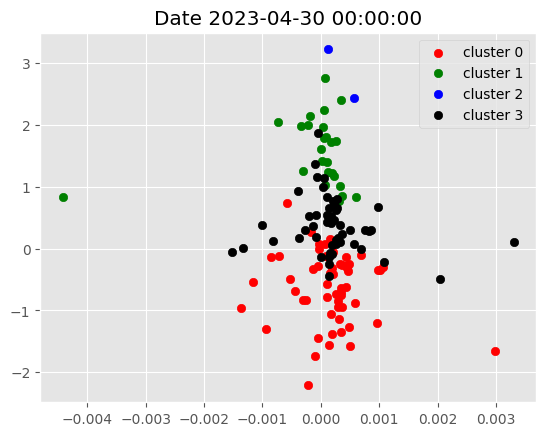

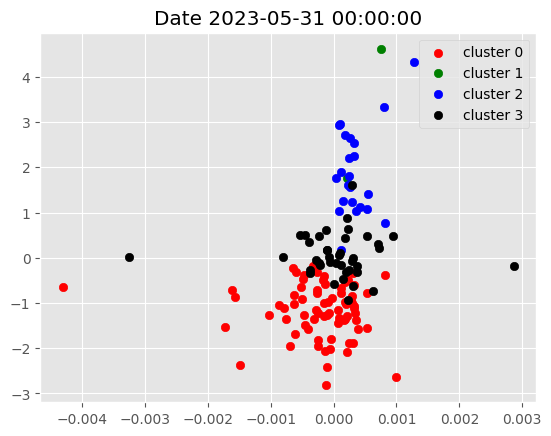

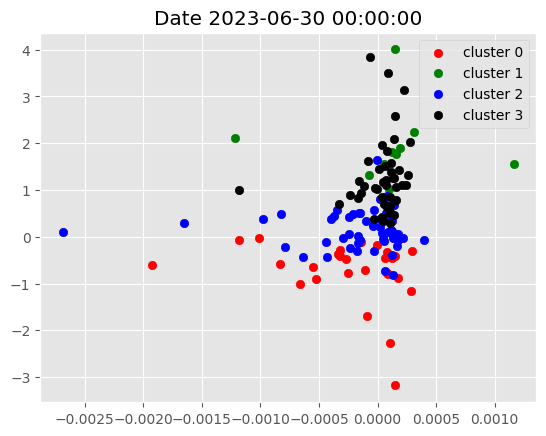

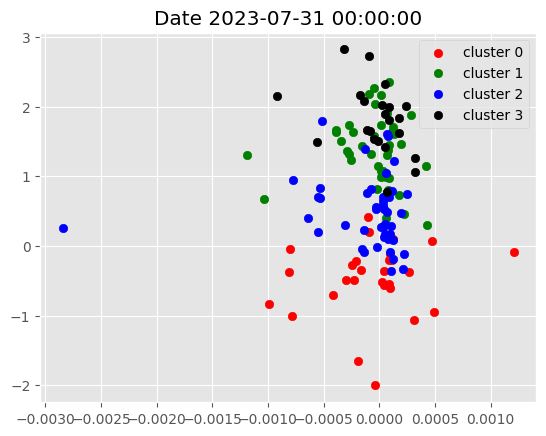

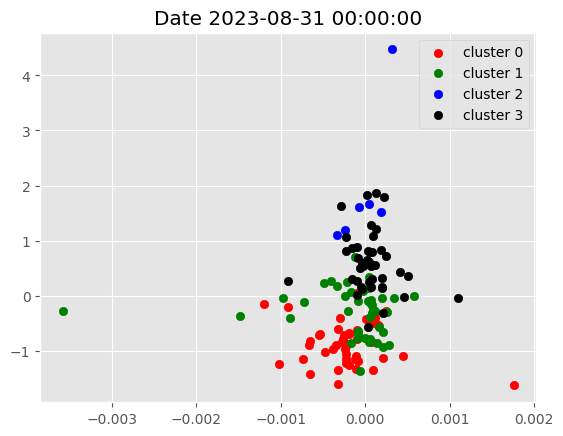

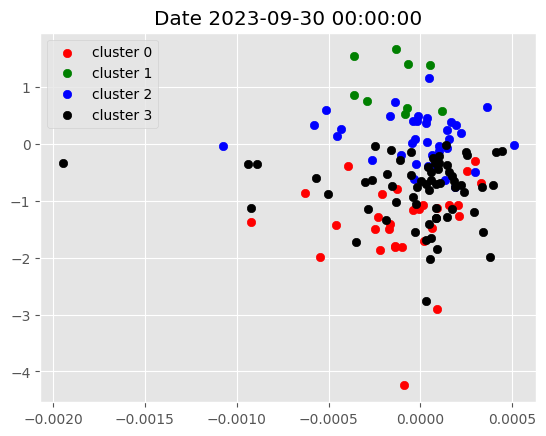

In [207]:
# Plot Clusters by Month
# Cluster 3 Corresponds to Stocks with Good Momentum in Previous Month (RSI -> 70)
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [208]:
# Apply Predefined Centroids
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month, select assets based on the cluster and form a portfolio based on Efficient Frontier Max Sharpe Ratio Optmization.
- First, filter only stocks corresponding to the cluster we choose based on our hypothesis.
- Strategy explanation: Momentum is persistent -> therefore, stocks around RSI 70 centroid should continue to outperform in the following month. Thus, select stocks corresponding to cluster 3.

In [216]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['ABBV',
  'ABT',
  'AZO',
  'BA',
  'BKNG',
  'BMY',
  'BRK-B',
  'C',
  'CCL',
  'COST',
  'CVX',
  'DAL',
  'DG',
  'EA',
  'EBAY',
  'FDX',
  'GM',
  'GS',
  'HAL',
  'HON',
  'IBM',
  'JNJ',
  'KO',
  'KR',
  'LMT',
  'LOW',
  'MDLZ',
  'MDT',
  'MO',
  'MS',
  'NFLX',
  'NKE',
  'ORLY',
  'OXY',
  'PANW',
  'RTX',
  'SBUX',
  'SCHW',
  'TGT',
  'TMO',
  'UNP',
  'UPS',
  'USB',
  'VZ',
  'WDC',
  'WYNN'],
 '2017-12-01': ['AAPL',
  'AMGN',
  'BIIB',
  'BMY',
  'CCL',
  'CL',
  'CMCSA',
  'CMG',
  'COP',
  'CRM',
  'DD',
  'EOG',
  'GD',
  'GILD',
  'GM',
  'GOOG',
  'GOOGL',
  'JNJ',
  'KO',
  'LLY',
  'MA',
  'MCK',
  'MDT',
  'META',
  'NVDA',
  'ORCL',
  'PANW',
  'PG',
  'PYPL',
  'STZ',
  'TGT',
  'TMO',
  'TXN',
  'ULTA',
  'V',
  'WBA'],
 '2018-01-01': ['ABBV',
  'ADBE',
  'AMZN',
  'C',
  'CCL',
  'CHTR',
  'CMCSA',
  'CSX',
  'CVS',
  'DD',
  'DHR',
  'DIS',
  'EBAY',
  'ELV',
  'F',
  'GD',
  'GOOG',
  'GOOGL',
  'GS',
  'HON',
  'HUM',
  'IBM',
  'JNJ',
 

In [217]:
# Define Portfolio Optmization Function
"""
1. Define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.
2. To optimize the weights of a given portfolio, we would need to supply last 1 year prices to the function.
3. Apply single stock weight bounds constraint for diversification (minimum half of equal weight and maximum 10% of portfolio).
"""
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [218]:
# Download Daily Price Data for Short Listed Stocks
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                          ...    Volume                   
Ticker            AAL        AAPL        ABBV  ...       WMT     WYNN       XOM
Date                                           ...                             
2016-10-31  39.134331   26.212477   40.245129  ...  19167000  1341600  16663800
2016-11-01  38.363209   25.739199   40.728527  ...  26515800  3722300  13050600
2016-11-02  38.276463   25.762291   40.973835  ...  22935900  2542400  11226100
2016-11-03  38.054211   25.486147   40.324482  ...  20411700  9050400   8836500
2016-11-04  38.402084   25.256418   40.432709  ...  21786300  3223800  13877100
...               ...         ...         ...  ...       ...      ...       ...
2023-09-25  12.910000  175.386337  150.264954  ...  10459500  1387800  11316000
2023-09-26  12.700000  171.282578  149.545944  ...  14435700  1454000  11805400
2023-09-27  12.610000  169.758591  148.788055  ...  15711000  2050000  23976200
2023-09-28  12.920000  170.017578  147.933014  ...  11617200  1290400  16808100
2023-09-29  12.810000  170.535538  144.833466  ...  18842400  1326800  18810700

[1740 rows x 930 columns]

In [223]:
# Calculate Daily Returns for Each Stock which could end up in our portfolio.
# Loop over each month start, select the stocks for the month, and calculate their weights for the next month.
# If the maximum sharpe ratio optmization fails for a given month, apply equally-weighted weights.
# Calculated daily portfolio return.

returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]
        # print(temp_df)
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-11-01,0.000283
2017-11-02,0.001796
2017-11-03,0.002760
2017-11-06,-0.000078
2017-11-07,-0.001387
...,...
2023-09-25,0.005372
2023-09-26,-0.014934
2023-09-27,0.006142


## 8. Visualize Portfolio Returns and Compare to SP500 Returns

In [225]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold_x,SPY Buy&Hold_y
2017-11-01,0.000283,0.001321,0.001321
2017-11-02,0.001796,0.000388,0.000388
2017-11-03,0.002760,0.003333,0.003333
2017-11-06,-0.000078,0.001546,0.001546
2017-11-07,-0.001387,-0.000695,-0.000695
...,...,...,...
2023-09-25,0.005372,0.004196,0.004196
2023-09-26,-0.014934,-0.014800,-0.014800
2023-09-27,0.006142,0.000399,0.000399
2023-09-28,0.009104,0.005781,0.005781


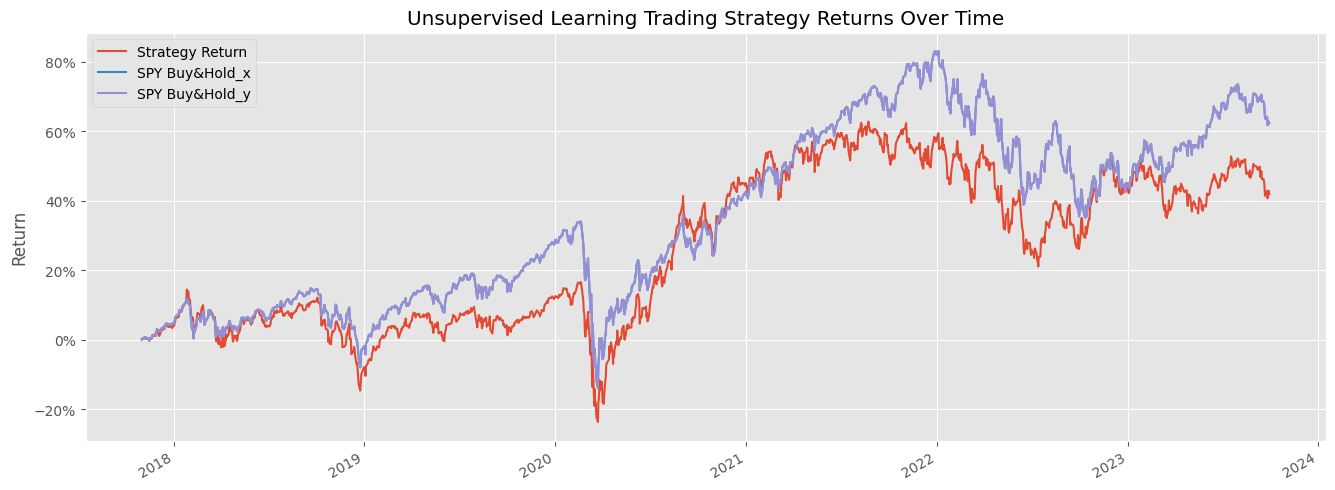

In [226]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()